# sentiment-based product recommendation system: 

    Performed following tasks:
    1.Data sourcing and sentiment analysis
    2.Building a recommendation system
    3.Recommending top 5 products
    4.Deploying the end-to-end project with a user interface


In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import random
import pickle
import pylab
from numpy import *


import matplotlib.pyplot as plt
import seaborn as sns
import time
from wordcloud import WordCloud
from collections import Counter


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection  import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.metrics import f1_score, classification_report,precision_score,recall_score,confusion_matrix, roc_auc_score, roc_curve

from sklearn.metrics.pairwise import pairwise_distances

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


In [2]:
#df = pd.read_csv('/content/gdrive/MyDrive/sample30.csv')
df = pd.read_csv('sample30.csv')
df.head(2)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive


### Preprocessing:
    Steps followed:
       1. Handling null values
       2. Preprocessing reviews text and visualization 

#### 1. Handling null values:
    Replaced NaN in reviews_title by empty space and merged reviews and reviews_title.

In [3]:
df.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [4]:
# only one null value in target change it into 0
# change positive to 1 and negative to 0
df['user_sentiment']= df['user_sentiment'].apply(lambda x:1 if x=='Positive' else 0)
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,1
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,1
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,1
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,0
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,0


In [5]:
# Replace nulls 
df['reviews_title'].fillna('',inplace=True)

In [6]:
# merge reviews columns
df['reviews']=df['reviews_text']+df['reviews_title']
df.drop(['reviews_text','reviews_title'],axis=1,inplace=True)
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment,reviews
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,Los Angeles,NaN,joshua,1,i love this album. it's very good. more to the...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,NaN,NaN,dorothy w,1,Good flavor. This review was collected as part...
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,NaN,NaN,dorothy w,1,Good flavor.Good
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,NaN,NaN,rebecca,0,I read through the reviews on here before look...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,NaN,NaN,walker557,0,My husband bought this gel for us. The gel cau...


In [7]:
# df_clean -> cleaned columns for recommendation and sentiment models
df_clean = df[['name','reviews_username','reviews','reviews_rating','user_sentiment']]
df_clean.head()

,name,reviews_username,reviews,reviews_rating,user_sentiment
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,i love this album. it's very good. more to the...,5,1
1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,Good flavor. This review was collected as part...,5,1
2,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,Good flavor.Good,5,1
3,K-Y Love Sensuality Pleasure Gel,rebecca,I read through the reviews on here before look...,1,0
4,K-Y Love Sensuality Pleasure Gel,walker557,My husband bought this gel for us. The gel cau...,1,0


In [8]:
df_clean.dropna(inplace=True)

<ipython-input-8-f60ba1d5b782>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.dropna(inplace=True)


In [9]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29937 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   name              29937 non-null  object
 1   reviews_username  29937 non-null  object
 2   reviews           29937 non-null  object
 3   reviews_rating    29937 non-null  int64 
 4   user_sentiment    29937 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.4+ MB


#### 2. Text preprocessing:
    Removed stops words after converting the text into lowercase. 

In [10]:
# function to convert text into lowercase, remove stopwords and special characters
def text_process(token):
    tokens = word_tokenize(token)
    words_lower = [word.lower() for word in tokens]
    words_nostop = [word for word in words_lower if word not in stopwords.words('english')]
    text = ' '.join(re.sub('[^a-zA-Z0-9]+', ' ', word) for word in words_nostop)
    return  text


In [11]:
# text preprocessing
df_clean['reviews'] = df_clean['reviews'].apply(lambda x:text_process(x))


<ipython-input-11-00799c6414be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['reviews'] = df_clean['reviews'].apply(lambda x:text_process(x))


In [12]:
# sample of a review
df_clean['reviews'][2000]

'wife really enjoyed movie   lots laughs very entertaining'

In [13]:
# df_clean -> save as .csv
df_clean.to_csv('df_clean.csv')

#### Visulaize:

(-0.5, 399.5, 199.5, -0.5)

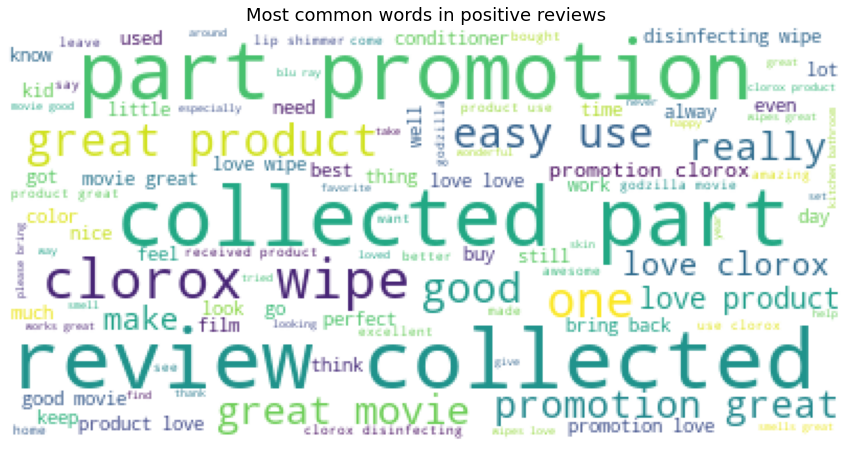

In [14]:
# Wordcloud to visualize Positive reviews
plt.figure(figsize=(15,15))
word_cloud = WordCloud(background_color="white", max_words=100, max_font_size=50)
pos_case=" ".join(df_clean[df_clean.user_sentiment==1]['reviews'].values)
word_cloud.generate(pos_case)
plt.title("Most common words in positive reviews", fontsize=18)
plt.imshow(word_cloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

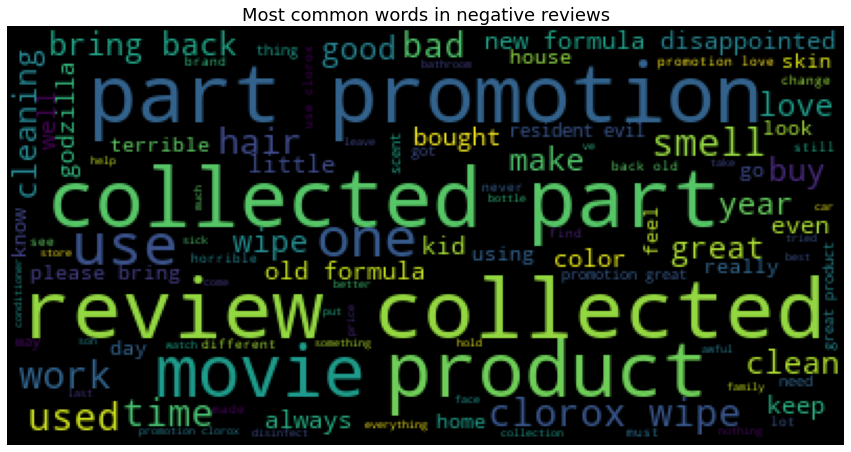

In [15]:
# Wordcloud to visualize Negative reviews
plt.figure(figsize=(15,15))
word_cloud = WordCloud(background_color="black", max_words=100, max_font_size=50)
neg_case=" ".join(df_clean[df_clean.user_sentiment==0]['reviews'].values)
word_cloud.generate(neg_case)
plt.title("Most common words in negative reviews", fontsize=18)
plt.imshow(word_cloud)
plt.axis('off')

<AxesSubplot:xlabel='user_sentiment', ylabel='count'>

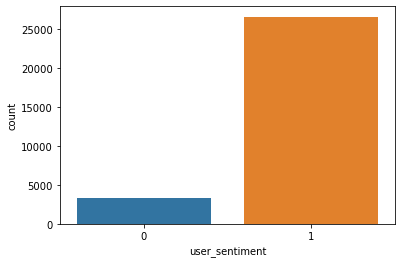

In [16]:
#Visualize target
sns.countplot(x='user_sentiment',data=df_clean)

Above plot shows imbalanced dataset.

# Sentiment analysis:

       To build sentiment analysis model, take reviews given by the users. 
       Steps followed:
       1. Feature extraction using tf-idf
       2. Handling imbalance
       3. Build 3 ML models 

In [17]:
# dataframe for sentiment analysis
Review = df_clean[['name','reviews','user_sentiment']]
Review.head()

,name,reviews,user_sentiment
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),love album s good hip hop side current po...,1
1,Lundberg Organic Cinnamon Toast Rice Cakes,good flavor review collected part promotion ...,1
2,Lundberg Organic Cinnamon Toast Rice Cakes,good flavor good,1
3,K-Y Love Sensuality Pleasure Gel,read reviews looking buying one couples lubric...,0
4,K-Y Love Sensuality Pleasure Gel,husband bought gel us gel caused irritation ...,0


In [18]:
# splitting into test and train

X_train, X_test, y_train, y_test = train_test_split(Review['reviews'], Review['user_sentiment'],test_size=0.30, random_state=42)

In [19]:
X_train.shape

(20955,)

#### 1. Feature extarction:
    Used tf-idf vectorizer to extract features from text.

In [20]:
# tf-idf
vectorizer= TfidfVectorizer(max_features=3000, lowercase=True, analyzer='word', stop_words= 'english')
tf_x_train = vectorizer.fit_transform(X_train).toarray()
tf_x_test = vectorizer.transform(X_test)

In [21]:
tf_x_train.shape

(20955, 3000)

#### 2. Handling imbalance:
    Used SMOTE to handle class imbalance.

In [22]:
# SMOTE
print('Before Sampling')
print(Counter(y_train))

sm = SMOTE(random_state=42)
X_train_sm ,y_train_sm = sm.fit_sample(tf_x_train,y_train)

print('After Sampling')
print(Counter(y_train_sm))

Before Sampling
Counter({1: 18570, 0: 2385})
After Sampling
Counter({1: 18570, 0: 18570})


#### 3. Model building:

#### Model 1. Logistic Regression:

In [23]:
lr=LogisticRegression()

params={'C':[10, 1, 0.5, 0.1],'penalty':['l1','l2'],'class_weight':['balanced']}


# Create grid search using 4-fold cross validation
grid_search = GridSearchCV(lr, params, cv=4, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_sm, y_train_sm)
model_LR = grid_search.best_estimator_
model_LR.fit(X_train_sm, y_train_sm)

C:\Users\prabh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\prabh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression(C=10, class_weight='balanced')

In [24]:
# Logitic model evalution
y_prob_test=model_LR.predict_proba(tf_x_test)
y_pred_test=model_LR.predict(tf_x_test)

print('Test Score:')
print('Confusion Matrix')
print('='*60)
print(confusion_matrix(y_test,y_pred_test),"\n")
print('Classification Report')
print('='*60)
print(classification_report(y_test,y_pred_test),"\n")
print('AUC-ROC=',roc_auc_score(y_test, y_prob_test[:,1]))
    

fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_test, y_prob_test[:,1])

AUC_ROC_LR = roc_auc_score(y_test, y_prob_test[:,1])


Test Score:
Confusion Matrix
[[ 672  301]
 [ 684 7325]] 

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.69      0.58       973
           1       0.96      0.91      0.94      8009

    accuracy                           0.89      8982
   macro avg       0.73      0.80      0.76      8982
weighted avg       0.91      0.89      0.90      8982
 

AUC-ROC= 0.914643431073239


#### Model 2 - Navie Bayes:

In [25]:
# Navie bayes
model_NB = MultinomialNB().fit(X_train_sm, y_train_sm)

In [26]:
#model evaluation

y_prob_test=model_NB.predict_proba(tf_x_test)
y_pred_test=model_NB.predict(tf_x_test)

print('Test Score:')
print('Confusion Matrix')
print('='*60)
print(confusion_matrix(y_test,y_pred_test),"\n")
print('Classification Report')
print('='*60)
print(classification_report(y_test,y_pred_test),"\n")
print('AUC-ROC=',roc_auc_score(y_test, y_prob_test[:,1]))
    

fpr_NB, tpr_NB, thresholds_NB = roc_curve(y_test, y_prob_test[:,1])

AUC_ROC_NB = roc_auc_score(y_test, y_prob_test[:,1])

Test Score:
Confusion Matrix
[[ 588  385]
 [1185 6824]] 

Classification Report
              precision    recall  f1-score   support

           0       0.33      0.60      0.43       973
           1       0.95      0.85      0.90      8009

    accuracy                           0.83      8982
   macro avg       0.64      0.73      0.66      8982
weighted avg       0.88      0.83      0.85      8982
 

AUC-ROC= 0.8261784628983042


#### Model 3 - Random Forest:

In [27]:
rf = RandomForestClassifier(random_state=42)

params_rf={'max_depth': [5, 10, 20],
          'min_samples_leaf': [5, 10, 20],
          'n_estimators': [10, 30, 50]
}

random_search = RandomizedSearchCV(rf, params_rf, cv=4, n_jobs=-1, verbose=1,scoring='roc_auc')

random_search.fit(X_train_sm, y_train_sm)
model_RF = random_search.best_estimator_

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.5min finished


In [28]:
#Random forest model evaluation


y_prob_test=model_RF.predict_proba(tf_x_test)
y_pred_test=model_RF.predict(tf_x_test)

print('Test Score:')
print('Confusion Matrix')
print('='*60)
print(confusion_matrix(y_test,y_pred_test),"\n")
print('Classification Report')
print('='*60)
print(classification_report(y_test,y_pred_test),"\n")
print('AUC-ROC=',roc_auc_score(y_test, y_prob_test[:,1]))
    

fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_test, y_prob_test[:,1])

AUC_ROC_RF = roc_auc_score(y_test, y_prob_test[:,1])

Test Score:
Confusion Matrix
[[ 604  369]
 [1221 6788]] 

Classification Report
              precision    recall  f1-score   support

           0       0.33      0.62      0.43       973
           1       0.95      0.85      0.90      8009

    accuracy                           0.82      8982
   macro avg       0.64      0.73      0.66      8982
weighted avg       0.88      0.82      0.84      8982
 

AUC-ROC= 0.836465322863269


#### Compare models:
    To select best model plot ROC.

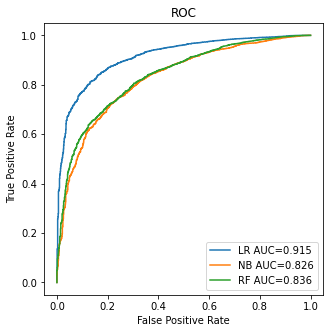

In [29]:
# ROC plot
plt.figure(figsize=(5, 5))
plt.plot( fpr_LR, tpr_LR, label=f'LR AUC={round(AUC_ROC_LR,3)}' )
plt.plot( fpr_NB, tpr_NB, label=f'NB AUC={round(AUC_ROC_NB,3)}' )
plt.plot( fpr_RF, tpr_RF, label=f'RF AUC={round(AUC_ROC_RF,3)}' )
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


#### Save model:
    From the plot Logistic regression performs better than other models.

In [30]:
# store tf-idf model
with open("tfidf_model.pkl", 'wb') as file:
    pickle.dump(vectorizer, file)

In [31]:
# save logistic regression model
with open('LR_sentiment_model.pkl', 'wb') as file:
    pickle.dump(model_LR, file)

In [32]:
# save logistic regression model
with open('df_sentiment_model.pkl', 'wb') as file:
    pickle.dump(df_clean, file)

# Recommendation system:
    1. Item based recommedation system
    2. User based recommendation system    

To build recommendation system taks user name , product name and review ratings.

In [33]:
# create recommedation data frame
recomm_df = df_clean[['reviews_username','reviews_rating','name']]
recomm_df.head()

,reviews_username,reviews_rating,name
0,joshua,5,Pink Friday: Roman Reloaded Re-Up (w/dvd)
1,dorothy w,5,Lundberg Organic Cinnamon Toast Rice Cakes
2,dorothy w,5,Lundberg Organic Cinnamon Toast Rice Cakes
3,rebecca,1,K-Y Love Sensuality Pleasure Gel
4,walker557,1,K-Y Love Sensuality Pleasure Gel


In [34]:
recomm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29937 entries, 0 to 29999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   reviews_username  29937 non-null  object
 1   reviews_rating    29937 non-null  int64 
 2   name              29937 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


**Create train and test set**

In [35]:
# Test and Train split of the dataset

train, test = train_test_split(recomm_df, test_size=0.30, random_state=31)

In [36]:
print(train.shape)
print(test.shape)

(20955, 3)
(8982, 3)


In [37]:
train.name.nunique()

255

In [38]:
train.reviews_username.nunique()

18212

In [39]:
# Pivot the train dataset into matrix format in which columns are products and the rows are user names.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(0)

df_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Citrus Magic Instant Spot & Stain Remover,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood ceiling mounted pot rack,Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84ct","Finish Qu

In [40]:
df_pivot.shape

(18212, 255)

**Creating Dummy train and test**

In the process of building a recommendation system, we do not want to recommend a product that the user has already rated or in some cases has performed some action on it such as view, like, share or comment. To eliminate these products from the recommendation list, you will need to take the help of a ‘dummy data set’.


In [41]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [42]:
# The movies not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [43]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(1)

dummy_train.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Citrus Magic Instant Spot & Stain Remover,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood ceiling mounted pot rack,Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84ct","Finish Qu

In [44]:
dummy_train.shape

(18212, 255)

#### User Similarity Matrix:

### Using adjusted Cosine similarity:

 Here, we are not removing the NaN values and calculating the mean only for the movies rated by the user

In [45]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
)
df_pivot.head(3)

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Citrus Magic Instant Spot & Stain Remover,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood ceiling mounted pot rack,Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84ct","Finish Qu

In [46]:
#Normalising the rating of the movie for each user around 0 mean
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Citrus Magic Instant Spot & Stain Remover,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood ceiling mounted pot rack,Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84ct","Finish Qu

#### Find cosine similarity:
    Used pairwise distance to find similarity.

In [47]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### Prediction:

In [48]:
# Ignore the correlation for values less than 0.
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user is the weighted sum of correlation with the product rating.

In [49]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 3.47249382, 0.        , ..., 6.05943587, 2.30940108,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [50]:
user_predicted_ratings.shape

(18212, 255)

In [51]:
# user_final_rating -> this contains predicted ratings for products
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Citrus Magic Instant Spot & Stain Remover,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood ceiling mounted pot rack,Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84ct","Finish Qu

#### Find the top 5 recommendation for the *user*

In [52]:
# Take the user ID as input [bob,00sab00]
#user_input = str(input("Enter your user name"))
user_input = str('00sab00') # for checking


In [53]:
# Recommended products for the selected user based on ratings
out_recommendation = user_final_rating.loc[user_input].sort_values(ascending=False)[:20]
out_recommendation

name
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                    59.497748
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                35.729246
The Resident Evil Collection 5 Discs (blu-Ray)                                     30.742364
Red (special Edition) (dvdvideo)                                                   14.335169
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                          13.632461
Coty Airspun Face Powder, Translucent Extra Coverage                                9.001445
Jason Aldean - They Don't Know                                                      8.855751
Windex Original Glass Cleaner Refill 67.6oz (2 Liter)                               6.059436
Alex Cross (dvdvideo)                                                               5.859790
Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack     5.789666
Lysol Concentrate Deodorizing Cleaner, Original Scent            

#### Evaluation - User User 

In [54]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1976, 3)

In [55]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', 
                                              values='reviews_rating')


In [56]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [57]:
user_correlation_df['userId'] = df_subtracted.index
user_correlation_df.set_index('userId',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,17962,17963,17964,17965,17966,17967,17968,17969,17970,17971,17972,17973,17974,17975,17976,17977,17978,17979,17980,17981,17982,17983,17984,17985,17986,17987,17988,17989,17990,17991,17992,17993,17994,17995,17996,17997,17998,17999,18000,18001,18002,18003,18004,18005,18006,18007,18008,18009,18010,18011,18012,18013,18014,18015,18016,18017,18018,18019,18020,18021,18022,18023,18024,18025,18026,18027,18028,18029,18030,18031,18032,18033,18034,18035,18036,18037,18038,18039,18040,18041,18042,18043,18044,18045,18046,18047,18048,18049,18050,18051,18052,18053,18054,18055,18056,18057,18058,18059,18060,18061,18062,18063,18064,18065,18066,18067,18068,18069,18070,18071,18072,18073,18074,18075,18076,18077,18078,18079,18080,18081,18082,18083,18084,18085,18086,18087,18088,18089,18090,18091,18092,18093,18094,18095,18096,18097,18098,18099,18100,18101,18102,18103,18104,18105,18106,18107,18108,18109,18110,18111,18112,18113,18114,18115,18116,18117,18118,18119,18120,18121,18122,18123,18124,18125,18126,18127,18128,18129,18130,18131,18132,18133,18134,18135,18136,18137,18138,18139,18140,18141,18142,18143,18144,18145,18146,18147,18148,18149,18150,18151,18152,18153,18154,18155,18156,18157,18158,18159,18160,18161,18162,18163,18164,18165,18166,18167,18168,18169,18170,18171,18172,18173,18174,18175,18176,18177,18178,18179,18180,18181,18182,18183,18184,18185,18186,18187,18188,18189,18190,18191,18192,18193,18194,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.612372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [58]:
common.head(1)

,reviews_username,reviews_rating,name
21169,jjjj,1,Nexxus Exxtra Gel Style Creation Sculptor


In [59]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]
user_correlation_df_1.shape

(1660, 18212)

In [60]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [61]:
user_correlation_df_3 = user_correlation_df_2.T
user_correlation_df_3.head()

,1234,123charlie,37f5p,4cloroxl,50cal,7.87E+11,aac06002,abbey,abbi,abby,abcdef,abigail,abismomy,ac94,acellacey,acjuarez08,aclass,acv4217,adam,adamsmom,adma2,adriana9999,afooey,afwifey2003,agmt,ah78,aj,aj1135,aj2012,ajeff,ajune,akhan,aktcharlotte,alex,alexis,alice,alisonr,alix p,allan6048,allen,ally,allyj1984,alm27,aluns,alvin,amanda01,amandarose,amazing,amber,ambr1207,ambybambi0725,ammi,amsey,amy1,anas79,anatnas4,andie,andiejo,andrea,andreafl,andream82,andrew,andy,ang32,angc,angel,angel65481,angela,angie,angie0104,angie447,angiesmessykids,anita,ann222,anna,anne,annie,annieb,annoymous,anon,anthony,aphoung,april,arcticfox,aria,arlene,arlingtondonna,arob,artfulhousewife,artlile,aryalynn,as123,ash23,ashley,ashleyden,ashleyfawne,ashsmash,askk808,at527,athenabear,atid,augale,aunt ape,auntie,aute8849,awesome,ayterrazas,azu12,b1g1free,babas,babygirl,badhairbob,bailee,baker,bakerbill,balletdancer83,bams,banana,bananakitty,barb,barb24,barber226,bargainhuntergmaoftwo,bargainshopper,barra2,barryjh,batman,batts,bb902460,bblack,bean,beanie,beautiful disaster,beccaruth,beebee,beechetu,behair,bel2006,bella,berly,bernie,berstann,beso,bessie,beth74,bethm,betsy,betty,beverly,bhemp,bigb,bigdaddybuttah,bigdogwood,bigred,bigred1,bill,billierose,bjhoneybear,bkenyon,bleachqueen,blindsay,blondie,blt66,blue,blue91,bluefox,blueheron,bluu,boardwalkempire,bob,bobb,bobby,bonbon,bonniebrooks,bonnieo,boo boo,booboo,bostongirl,bostonmommy,bowbow,boysmom,brady,brandi1982,brandon,brandy33,brecca,brett,brian,brianskupa,britt,brittany,browndiva007,bryan,btechthor,bubba,bubba1976,bubby,buckeye,buckster,bunny,burntpopcorn,buster,busybee1995,busymom,buty,bwbstr435,bwoh,by...,byamazon customer,bybarbara edwards,byc. coombs,bydave,bykindle customer,bymugwhamp,byweedydave,bzmama,bzylema,c2d2,cabello,cahy,cait,calicutie,cally,cami,candice16542,cangel83,canyons422,capnscrummy,carlos,carol,carol29,carrie,carriea,carrieletti,caseo,casey,cass,cassie,cassieh,castle,cate1,catfan,catherine4155,cathy,cathy123,cathyw,ccl,cdavadi,cdedbdb,cece1,...,shorty07,sissy,sjdeste,sjohnny,skeeter,skladj,skwr,sl5xm,sleestak50,slim,slouchycowman,sm01,smh1234,smiley,smiley82,smithx3,smontell,smorrison,snoopy,sofi,solathe2007,solstice53,somerandomguy,somergirl,soph,sorensen777,sous,southernhands,sparkle183,sparky,spat,spedteacher,spiderman13,spunky,spunkytoo,squat,squeak,squirrel,sriracha,sriske,sselliott,ssibeachbum,stacey,stacey15,staci,stacy,star,state,stayhomemother,stef31,steffunnyywhoo,stellasmama,steph,steph2026,steph65,stephanie1219,stephanie78,stephanie8810,stephcakes,stephhh,steponme,steve,steveo,stevie,still unhappy,stirfry,storytyty,stouticus,stra,sue,suebell,summer2474,sunny1,sunny2,sunshan,sunshine,sup3rmom,supergirl,superj,superjenn,supertaz93,suri,susan,susanb,susie72,susu,suzanne4391,suzyq,suzzz,swandive,sweet,sweetpea626,swess12,swimmer2005,swtdrmz,syd07,sydk,sydmikery,taco99,takisha56ett,taliacrayon24,tamberlyb,tami62,tammy,tamtam,tangon,tania13,tara85,taraburger,tarheelfan,tasha marie,tashafierce,tat2me82,tata87,taurusanaya,tausha,taylorsmom12,taymackk,tb10,teacher,teckys4,tee1969,teecherbabe,teerudy,tenaj842,ter86,terry,tess,tess22,tetter74,texasmomma7899,texsangel,thatguy,thatoneguy,the boss,thebeast13,thebestthing,thecorleys2011,thedoctor,themoviemaniac,thenaptimereviewer,theoslithos,theresah,thetank,thomas,thomcat11,tiaalese,tiff,tiff4199,tiffy,tigmommy,timm,timothy,tina,tina71,tinaj,tinanmel,tink,tink0917,tmc1,tmoxvan,tncq,toby,todd,tone,toni,tony,tony1,tootsie23,torrie,toshcal,totesaddicted,tracelyn28,tracy,trcvngrn,treese,trice,trina,trish,trish626,trix,ttdebbi,tucker65,turi,turtle,tw350z,tweetyanne,twiggy575,txmomof6,tycr,typist,tyreese,val214,vallink,vanita80,vc13,vccaan,venus24,veroo,vet323tech,vick88,vicki,victoria harris,viewer,viking80,vikki,vivian,vivienne,vlo910,voxemluth,vyph,wackibanan,walker,wally,warren,wasabi42,wendy2245,whome,wildchild23,willy,wimbly,wise,wiseman378,wizard,wolf,wolfie,wolvarine,wonderwoman,woody,woottos,woowoo,worm,wownostreaks,wren113,x

In [62]:
user_correlation_df_3.shape

(1660, 1660)

In [63]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [64]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

In [65]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Batherapy Natural Mineral Bath Sport Liquid, 16 oz","Beanitos Bean Chips, Simply Pinto Bean",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bisquick Original Pancake And Baking Mix - 40oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets","Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cantu Coconut Milk Shine Hold Mist - 8oz,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Coty Airspun Face Powder, Translucent Extra Coverage","Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Gain Original Scent Liquid Fabric Softener 129 Oz,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1,Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans","Iman Second To None Stick Foundation, Clay 1",Jason Aldean - They Don't Know,"Johnson's Baby Bubble Bath and Wash, 15oz",Jolly Time Select Premium Yellow Pop Corn,"Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",K-Y Love Sensuality Pleasure Gel,"Kikkoman Soy Sauce, 5fl oz",Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,L'oreal Paris Advanced Hairstyle Boost It High Lift Creation Spray,L'oreal Paris Advanced Hairstyle TXT IT Hyper-Fix Putty,"L'oreal Paris Colour Caresse Wet Shine Stain, Pink Resistance","Lundberg Wehani Rice, 25lb",Lynk Professional174 Pull Out Cutting Board Bakeware Sliding Cabinet Organizer,"Lysol Concentrate Deodorizing Cleaner, Original Scent",Meguiar's Deep Crystal Car Wash 64-Oz.,Meguiar's Ultimate Quik Detailer 22-Oz.,Mike Dave Need Wedding Dates (dvd + Digital),Mill Creek Aloe Vera & Paba Lotion,Moom Express Pre Waxed Strips For Face & Bikini,Mrs. Meyer's Lemon Verbena Surface Scrub,Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),Nature's Path Chunky Chocolate Peanut Chewy Granola Bars,Naturtint Nutrideep Multiplier Protective Cream,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum SPF 50, 5oz","Newman's Own Balsamic Vinaigrette, 16.0oz","Newman's Own Organics Licorice Twist, Black 5oz",Nexxus Exxtra Gel Style Creation Sculptor,"Ogx Conditio

#### Find rmse :

In [66]:
X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


C:\Users\prabh\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:373: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\prabh\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:374: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [67]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [68]:
common_.head()

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Batherapy Natural Mineral Bath Sport Liquid, 16 oz","Beanitos Bean Chips, Simply Pinto Bean",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bisquick Original Pancake And Baking Mix - 40oz,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets","Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cantu Coconut Milk Shine Hold Mist - 8oz,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,Ceiling Fan With Light White 14.2 X 29.9 X 9.2 - Hunter Fan,CeraVe SA Renewing Cream,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,"Coty Airspun Face Powder, Translucent Extra Coverage","Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Gain Original Scent Liquid Fabric Softener 129 Oz,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1,Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans","Iman Second To None Stick Foundation, Clay 1",Jason Aldean - They Don't Know,"Johnson's Baby Bubble Bath and Wash, 15oz",Jolly Time Select Premium Yellow Pop Corn,"Just For Men Touch Of Gray Gray Hair Treatment, Black T-55",K-Y Love Sensuality Pleasure Gel,"Kikkoman Soy Sauce, 5fl oz",Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,L'oreal Paris Advanced Hairstyle Boost It High Lift Creation Spray,L'oreal Paris Advanced Hairstyle TXT IT Hyper-Fix Putty,"L'oreal Paris Colour Caresse Wet Shine Stain, Pink Resistance","Lundberg Wehani Rice, 25lb",Lynk Professional174 Pull Out Cutting Board Bakeware Sliding Cabinet Organizer,"Lysol Concentrate Deodorizing Cleaner, Original Scent",Meguiar's Deep Crystal Car Wash 64-Oz.,Meguiar's Ultimate Quik Detailer 22-Oz.,Mike Dave Need Wedding Dates (dvd + Digital),Mill Creek Aloe Vera & Paba Lotion,Moom Express Pre Waxed Strips For Face & Bikini,Mrs. Meyer's Lemon Verbena Surface Scrub,Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),Nature's Path Chunky Chocolate Peanut Chewy Granola Bars,Naturtint Nutrideep Multiplier Protective Cream,"Neutrogena Wet Skin Sunscreen Spray Broad Spectrum SPF 50, 5oz","Newman's Own Balsamic Vinaigrette, 16.0oz","Newman's Own Organics Licorice Twist, Black 5oz",Nexxus Exxtra Gel Style Creation Sculptor,"Ogx Conditio

In [69]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [70]:
rmse_user = round((sum(sum((common_ - y )**2))/total_non_nan)**0.5,2)
print(rmse_user)

2.41


# Item Based Similarity:

In [71]:
# take transpose of user based df
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,11677j,1234,1234567,1234asdf,123charlie,123rs,123soccermom,123too,12gage,132457,13dani,13ld,13ram,13thfaerie,1421nikki,143st,148maine,1515,15425shopper,1616,170361eggs,17roses,18612,1863philly,1943,1950rmm,1970,1979edes,19bubba67,19granny,1awesome1,1cadet,1chynna,1clean1,1cleaner,1cocoafan,1derpet1,1disappoint,1glenn,1gra,1gussy,1happymom,1hotmama,1izzy1,1jodie,1kindword,1officegal,1okc2thunder3up4,1pleasedclient,1scooby1,1shop,1sonny,1stcavdivision,1sttimemama,1texasmom,1wildbill2l,1witch,2011mom2b,2013bestbuyer,2014bestbuys,2015mom,2016,2016home,2016parker10,2062351337,210tundra,2175046722,21honey,232323,2455,2532674594,25happyshopper,2689,28green,295259,2athome,2bgreen,2busy4u,2choclabs,2clean4me,2cutekids,2dobies,2ds4es14,2esinapod,2hearts1love,2iceskates,2rogersmakearight,2sweetdaisies,2total,2w0cat5z,30103,3276teev,3375509742,37f5p,3babiesat41,3bear,3boys2turtles5chicks,3dcav,3dfan,3dknights,3dmoviewatcher,3dpenguin,3kids,3lilones,3ringbandb,3ringcircus,3sawhorsesneeded,3scissors,3skyyblue,4 rooms 1 dog lotsa fur,4048197640,405april,4112,44pam44,45177ss,45cleanupwoman,45mindishqueen,49erfaithful,4cloroxl,4djs,4dogmom,4frugal,4gis1975,4luds,4momma88,4my5goldens,4shop,4stew57,4th grade teacher,4theloveofclorox,4wipes,500mpl,50cal,5150seriousshopper5150,530germkiller,54867906,551580,5742870423,57susie,5alarm,5boysohmy,5kids,5mcdaniels,5star414,5zenuff,63lamb,64falcon,66babe,6787249844,67firebird,6utefans,7,7.87E+11,70cohoosier,714reginald,72443,74corvetteguy,7737593842,7autumn5,7frances7,7inthenest,7of9,7rick,8.84E+11,80021mom,80204,8023,808wrx,81t21,827,85721747267,8574178605,85lisa,88brit06,8ellie24,8sk8anddon8,8thred,9373weld,987654321abc,98nd500,99runner,9thdoctor,_christenak,a hutch,a11mxdup,a1cbee1481,a786,aabrannon,aac06002,aac3,aagbaghagmom,aakon,aalyah,aarhus74,aaron,aaronabigail,aaronlab,aaulvu,ab1015,ab45,ab86,ababe,abacadaba,abam,abananie,abarker1215,abartine,abashli,abaybay,abberdoodlesmom,abbey,abbey64,abbi,abbuyguy,abby,abby1,abby11,abby132,abbysmama,abc,abc1245,abc4sb206,abcd12345,abcdef,abcdefghij,abcssds,abctech,abd1,abear93,abel9027,abelc,abesb,abeverly7,abg0821,abigail,abigail81,abigailc,abihaven,...,wordyone,working1,workingit,workingmom,workingmomof1,worm,wowiezowie,wownostreaks,wowwie,wr777,wreckzu,wren113,wrenny,wright11,wrigleysmom,write2kjf,writerstone,wsnug,wspeedracerz28,wtchawmn,wut54,wuv2sh0p,wvdeb56,wvmommy,wvpcollins,wvu1,wwednesday7,wwphf,wyatt,wyatt09,wynn,wynnepoohplayer,wyoshopgril,xanadu72,xander,xander126,xavenger,xavier,xbflysky,xblazingsaddles,xbox1gamer,xcartersmommyx,xcelerate,xcoach98,xcrisstanicolex,xenawp,xeon500cc,xfilipinox,xhulia,xiaodan z,xiihong,xjryan,xkatie,xl,xlivayy,xman,xmhana,xmom,xnrcr3,xolisa,xolittlebit,xoxorosita,xpjunk,xplnusa,xqhinc,xracer,xray,xsbluesugar,xsnitro,xstr8edgex,xxacw12xx,xxcris,xxfloridagirlxx,xxyy,xyzmom,xzxsarahzxz,yadleyburg420,yagerbomb07,yago,yaii,yalc,yamel97,yams2536,yang,yangko,yankee23,yankeegirl7980,yankeemama73,yankees500,yaquiv,yard12,yarethv,yari34,yary27,yassi,yata32,yayatex,yayawomack,yaytay321,yazh,yazzmiin,ybadilla,ycyc,ydteoo,yeag350,yeapmsb,yeknom,yelley,yellow,yellow09,yes22,yes2carrotslover,yesseniaw22,yessi,yessi819,yesss,yexzenica,yeya,yeyo,yg007,yglesias99,ygtz,yharkins,yiayiamre,yj45,ymdunn,ymontes923,yoad78,yoadrian,yogagirl,yognap,yogore,yogurt,yojamey,yoko47,yoko76,yolandas,yoli1987,yolita,yoliwill,yolo,yolonda24,yoly,yolyrn,yoma,yonino,yonoegwa,yoolie,yoona,yooper,yopack,yoperla,yorissa,yorkie6,yorkielvr,yorkster88,yosh,yoshi,yoski,yosuerte,youjon,youknowit459,younggrannie62,yourbugginme04,yourmom,youthfulone,yoyo1245,yozer29,yram,yrina03,yshan,yulkakapulka,yummy,yvonne,yyz2112123,yzkgsx,z33pisces,zabdelra,zach,zacharymcneill,zachizz,zachsmom,zacroxs,zaibo,zak08,zakkwylde29,zakkzakk,zamanda,zanarkandruinsx2,zanay,zapaduh,zapman,zara07,zarah,zaza,zburt5,zebras,zebrastrong,zee74,zeek,zeek0

Normalising the movie rating for each movie for using the Adujsted Cosine

In [72]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T
df_subtracted.head()

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,11677j,1234,1234567,1234asdf,123charlie,123rs,123soccermom,123too,12gage,132457,13dani,13ld,13ram,13thfaerie,1421nikki,143st,148maine,1515,15425shopper,1616,170361eggs,17roses,18612,1863philly,1943,1950rmm,1970,1979edes,19bubba67,19granny,1awesome1,1cadet,1chynna,1clean1,1cleaner,1cocoafan,1derpet1,1disappoint,1glenn,1gra,1gussy,1happymom,1hotmama,1izzy1,1jodie,1kindword,1officegal,1okc2thunder3up4,1pleasedclient,1scooby1,1shop,1sonny,1stcavdivision,1sttimemama,1texasmom,1wildbill2l,1witch,2011mom2b,2013bestbuyer,2014bestbuys,2015mom,2016,2016home,2016parker10,2062351337,210tundra,2175046722,21honey,232323,2455,2532674594,25happyshopper,2689,28green,295259,2athome,2bgreen,2busy4u,2choclabs,2clean4me,2cutekids,2dobies,2ds4es14,2esinapod,2hearts1love,2iceskates,2rogersmakearight,2sweetdaisies,2total,2w0cat5z,30103,3276teev,3375509742,37f5p,3babiesat41,3bear,3boys2turtles5chicks,3dcav,3dfan,3dknights,3dmoviewatcher,3dpenguin,3kids,3lilones,3ringbandb,3ringcircus,3sawhorsesneeded,3scissors,3skyyblue,4 rooms 1 dog lotsa fur,4048197640,405april,4112,44pam44,45177ss,45cleanupwoman,45mindishqueen,49erfaithful,4cloroxl,4djs,4dogmom,4frugal,4gis1975,4luds,4momma88,4my5goldens,4shop,4stew57,4th grade teacher,4theloveofclorox,4wipes,500mpl,50cal,5150seriousshopper5150,530germkiller,54867906,551580,5742870423,57susie,5alarm,5boysohmy,5kids,5mcdaniels,5star414,5zenuff,63lamb,64falcon,66babe,6787249844,67firebird,6utefans,7,7.87E+11,70cohoosier,714reginald,72443,74corvetteguy,7737593842,7autumn5,7frances7,7inthenest,7of9,7rick,8.84E+11,80021mom,80204,8023,808wrx,81t21,827,85721747267,8574178605,85lisa,88brit06,8ellie24,8sk8anddon8,8thred,9373weld,987654321abc,98nd500,99runner,9thdoctor,_christenak,a hutch,a11mxdup,a1cbee1481,a786,aabrannon,aac06002,aac3,aagbaghagmom,aakon,aalyah,aarhus74,aaron,aaronabigail,aaronlab,aaulvu,ab1015,ab45,ab86,ababe,abacadaba,abam,abananie,abarker1215,abartine,abashli,abaybay,abberdoodlesmom,abbey,abbey64,abbi,abbuyguy,abby,abby1,abby11,abby132,abbysmama,abc,abc1245,abc4sb206,abcd12345,abcdef,abcdefghij,abcssds,abctech,abd1,abear93,abel9027,abelc,abesb,abeverly7,abg0821,abigail,abigail81,abigailc,abihaven,...,wordyone,working1,workingit,workingmom,workingmomof1,worm,wowiezowie,wownostreaks,wowwie,wr777,wreckzu,wren113,wrenny,wright11,wrigleysmom,write2kjf,writerstone,wsnug,wspeedracerz28,wtchawmn,wut54,wuv2sh0p,wvdeb56,wvmommy,wvpcollins,wvu1,wwednesday7,wwphf,wyatt,wyatt09,wynn,wynnepoohplayer,wyoshopgril,xanadu72,xander,xander126,xavenger,xavier,xbflysky,xblazingsaddles,xbox1gamer,xcartersmommyx,xcelerate,xcoach98,xcrisstanicolex,xenawp,xeon500cc,xfilipinox,xhulia,xiaodan z,xiihong,xjryan,xkatie,xl,xlivayy,xman,xmhana,xmom,xnrcr3,xolisa,xolittlebit,xoxorosita,xpjunk,xplnusa,xqhinc,xracer,xray,xsbluesugar,xsnitro,xstr8edgex,xxacw12xx,xxcris,xxfloridagirlxx,xxyy,xyzmom,xzxsarahzxz,yadleyburg420,yagerbomb07,yago,yaii,yalc,yamel97,yams2536,yang,yangko,yankee23,yankeegirl7980,yankeemama73,yankees500,yaquiv,yard12,yarethv,yari34,yary27,yassi,yata32,yayatex,yayawomack,yaytay321,yazh,yazzmiin,ybadilla,ycyc,ydteoo,yeag350,yeapmsb,yeknom,yelley,yellow,yellow09,yes22,yes2carrotslover,yesseniaw22,yessi,yessi819,yesss,yexzenica,yeya,yeyo,yg007,yglesias99,ygtz,yharkins,yiayiamre,yj45,ymdunn,ymontes923,yoad78,yoadrian,yogagirl,yognap,yogore,yogurt,yojamey,yoko47,yoko76,yolandas,yoli1987,yolita,yoliwill,yolo,yolonda24,yoly,yolyrn,yoma,yonino,yonoegwa,yoolie,yoona,yooper,yopack,yoperla,yorissa,yorkie6,yorkielvr,yorkster88,yosh,yoshi,yoski,yosuerte,youjon,youknowit459,younggrannie62,yourbugginme04,yourmom,youthfulone,yoyo1245,yozer29,yram,yrina03,yshan,yulkakapulka,yummy,yvonne,yyz2112123,yzkgsx,z33pisces,zabdelra,zach,zacharymcneill,zachizz,zachsmom,zacroxs,zaibo,zak08,zakkwylde29,zakkzakk,zamanda,zanarkandruinsx2,zanay,zapaduh,zapman,zara07,zarah,zaza,zburt5,zebras,zebrastrong,zee74,zeek,zeek0

Finding the cosine similarity using pairwise distances approach . 

In [73]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          1.          0.         ... -0.00755288  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.         -0.00755288  0.         ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [74]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

#### Predicition

In [75]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.006633  , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00221326,
        0.00987742],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00368876,
        0.01646236],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00045358, 0.00152992,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00045358, 0.00152992,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00036287, 0.00122393,
        0.        ]])

In [76]:
item_predicted_ratings.shape

(18212, 255)

In [77]:
dummy_train.shape

(18212, 255)

Filter the rating only for the products not rated by the user for recommendation.

In [78]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bill Glor Gaither - Church In The Wildwood (cd),Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Black Sister's Revenge (dvd),Blue Anchor Design Throw Pillow (18x18) - Rizzy Home,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Cal Lighting Led Dark Bronze Finish Metal Piano Lamp,Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,"Carson-Dellosa Publishing Photographic Learning Cards Boxed Set, Nouns/verbs/adjectives, Grades K-12",CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Citrus Magic Instant Spot & Stain Remover,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Clorox Ultimate Care Premium Bleach,Cococare 100% Natural Castor Oil,"Colorganics Lipstick, Cayenne",Concept Housewares 36 Natural Wood ceiling mounted pot rack,Coola Organic Sunscreen Classic Face Cucumber SPF 30,"Coty Airspun Face Powder, Translucent Extra Coverage",Craft Punch Giga Scallop Circle 45 24687534 To 334,"Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Elvis Presley - Girl Happy (cd),Equals (blu-Ray),Fantasy Fields Lil' Sports Fan Step Stool - Teamson,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84ct","Finish Qu

In [79]:
# Take the user ID as input [bob,00sab00]
#user_input = str(input("Enter your user name"))
user_input = str('00sab00') # for checking


In [80]:
# Recommending the Top 5 products to the user.
d = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d

name
Bilbao Nightstand Gray Oak - South Shore                                0.158656
Vicks Vaporub, Regular, 3.53oz                                          0.133356
Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo)            0.086135
Equals (blu-Ray)                                                        0.080092
Wagan Smartac 80watt Inverter With Usb                                  0.062017
Various - Red Hot Blue:Tribute To Cole Porter (cd)                      0.062017
Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White                  0.058509
Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans                         0.045737
D-Con Mice Bait Station - 3ct                                           0.041633
The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus                0.034111
Musselman Apple Sauce, Cinnamon, 48oz                                   0.033075
Chex Muddy Buddies Brownie Supreme Snack Mix                            0.032873
The Resident Evil Colle

#### Evaluation:
    Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the products already rated by the user insead of predicting it for the products not rated by the user. 

In [81]:
common =  test[test.name.isin(train.name)]
common.shape

(8964, 3)

In [82]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T
common_item_based_matrix.shape

(203, 8348)

In [83]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02265,0.0,0.0,0.0,0.0,0.0,0.0,0.011177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006633,0.0,0.0,0.0,0.009486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000

In [84]:
item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02265,0.0,0.0,0.0,0.0,0.0,0.0,0.011177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006633,0.0,0.0,0.0,0.009486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [85]:
list_name = common.name.tolist()

In [86]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [87]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T
item_correlation_df_3.head(3)

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Annie's Homegrown Deluxe Elbows & Four Cheese Sauce,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,Arrid Extra Dry Anti-Perspirant Deodorant Spray Regular,"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,Baxter Of California Cream Pomade,"Beanitos Bean Chips, Simply Pinto Bean",Bedtime Originals Pinkie Musical Mobile,"Ben & Jerry's Coffee, Coffee Buzzbuzzbuzz! Ice Cream, Pint","Better Built 74010862 Bet74010862 60In Crossover Two Lid, Deep, Truck Tool Box",Bi-O-kleen Spray & Wipe All Purpose Cleaner,Bilbao Nightstand Gray Oak - South Shore,Bisquick Original Pancake And Baking Mix - 40oz,Black Front Loading Frame Set (8.5x11) Set Of 12,Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home,"Bounce Dryer Sheets, Fresh Linen, 160 sheets",Bumble Bee Solid White Albacore In Water - 5 Oz,"Burt's Bees Lip Shimmer, Raisin","Burt's Bees Lip Shimmer, Watermelon",Calvin Klein Secret Obsession Eau De Parfum,Cantu Coconut Milk Shine Hold Mist - 8oz,Care Free Curl Gold Instant Activator,"Caress Moisturizing Body Bar Natural Silk, 4.75oz",Cars Toon: Mater's Tall Tales,CeraVe SA Renewing Cream,"Cetaphil Gentle Skin Cleanser, 2oz",Charcoal Stone Toothbrush Holder Gray,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,Chester's Cheese Flavored Puffcorn Snacks,Chex Muddy Buddies Brownie Supreme Snack Mix,Chips Ahoy! Original Chocolate Chip - Cookies - Family Size 18.2oz,Chips Deluxe Soft 'n Chewy Cookies,Chobani174 Strawberry On The Bottom Non-Fat Greek Yogurt - 5.3oz,Clambake (dvd),Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,Clorox Disinfecting Bathroom Cleaner,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,Cococare 100% Natural Castor Oil,Concept Housewares 36 Natural Wood ceiling mounted pot rack,"Coty Airspun Face Powder, Translucent Extra Coverage","Creme Of Nature Intensive Conditioning Treatment, 32",Cuisinart174 Electric Juicer - Stainless Steel Cje-1000,D-Con Mice Bait Station - 3ct,Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo),Delta Single Handle Shower Faucet,"Dermalogica Special Cleansing Gel, 8.4oz",Diet Canada Dry Ginger Ale - 12pk/12 Fl Oz Cans,Doc Mcstuffins: Friendship Is The Best Medicine,Eagle Fat Free Sweetened Condensed Milk,Equals (blu-Ray),Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,"Finish Gelpacs Dishwasher Detergent, Orange Scent, 84ct","Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",Fiskars174 Classic Stick Rotary Cutter (45 Mm),Gain Original Scent Liquid Fabric Softener 129 Oz,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,Happy Tot Apple and Butternut Squash,Hawaiian Punch Berry Limeade Blast Juice,Head & Shoulders Classic Clean Conditioner,Head & Shoulders Dandruff Shampoo Ocean Lift 2 In 1,Heiress (dvd),Hollywood Beauty Olive Cholesterol,Holmes174 Personal Indoor Heater W/ Manual Controls White 1500w Hfh131-N,Home Health Hairever Shampoo,Honeywell Heatbud Ceramic Heater Black,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,"Hormel Chili, No Beans",If A Man Answers (dvd),"Iman Second To None Stick Foundation, Clay 1","J.R. Watkins Hand Cream, Lemon Cream"

In [88]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02105944, 0.00045358, 0.00036287, ..., 0.00045358, 0.00018143,
        0.        ],
       [0.        , 0.00152992, 0.00122393, ..., 0.00152992, 0.00061197,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [89]:
common_item_predicted_ratings.shape

(203, 8348)

Dummy test will be used for evaluation. To evaluate, we will only make prediction 
on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.


In [90]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [91]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

#### Find rmse:

In [92]:

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


C:\Users\prabh\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:373: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\prabh\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:374: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [93]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [94]:
rmse_item = round((sum(sum((common_ - y )**2))/total_non_nan)**0.5,2)
print(rmse_item)

3.58


### Recommendation system for capstone:

Based on Rmse , selected user-user based recommendation system.

### Save model :

In [95]:
user_final_rating.to_csv('user_based_recomm.csv')

In [96]:
pickle.dump(user_final_rating, open('user_based_recomm_model.pkl','wb'))

## Recommendation of Top 20 Products to a Specified User

In [97]:
# load all pkl files
tfidf_model = pickle.load(open('tfidf_model.pkl', 'rb'))
user_based_recomm_model = pickle.load(open('user_based_recomm_model.pkl', 'rb'))
LR_sentiment_model = pickle.load(open('LR_sentiment_model.pkl', 'rb'))

In [98]:
# Enter user name

user = str('00sab00')  # for e.g

In [99]:
# Recommend top 20 products
user_top20 = user_based_recomm_model.loc[user].sort_values(ascending=False)[:20]

In [100]:
user_top20 = pd.DataFrame(user_top20)  #.to_records())
user_top20.reset_index(inplace = True)
user_top20

,name,00sab00
0,Godzilla 3d Includes Digital Copy Ultraviolet ...,59.497748
1,Planes: Fire Rescue (2 Discs) (includes Digita...,35.729246
2,The Resident Evil Collection 5 Discs (blu-Ray),30.742364
3,Red (special Edition) (dvdvideo),14.335169
4,Clorox Disinfecting Wipes Value Pack Scented 1...,13.632461
5,"Coty Airspun Face Powder, Translucent Extra Co...",9.001445
6,Jason Aldean - They Don't Know,8.855751
7,Windex Original Glass Cleaner Refill 67.6oz (2...,6.059436
8,Alex Cross (dvdvideo),5.859790
9,"Pendaflex174 Divide It Up File Folder, Multi S...",5.789666


In [101]:
# merge top 20 products and its reviews
top20_products_setiment = pd.merge(user_top20,df_clean,on = ['name'])
top20_products_setiment.head()

,name,00sab00,reviews_username,reviews,reviews_rating,user_sentiment
0,Godzilla 3d Includes Digital Copy Ultraviolet ...,59.497748,primoconcept,could left one shelf great boxawful,1,1
1,Godzilla 3d Includes Digital Copy Ultraviolet ...,59.497748,terrym,movie much worse expected 1997 broderick mov...,1,1
2,Godzilla 3d Includes Digital Copy Ultraviolet ...,59.497748,mrme,n t get hype godzilla frankly movie boring ...,1,0
3,Godzilla 3d Includes Digital Copy Ultraviolet ...,59.497748,3dknights,little disappointed like godzilla movies years...,1,0
4,Godzilla 3d Includes Digital Copy Ultraviolet ...,59.497748,master,sale bought got case broken half witch suc...,1,0


Feed 'top20_products' into tfidf model first and into sentiment model to find sentiment score.

In [102]:
# convert text to feature
top20_products_tfidf = tfidf_model.transform(top20_products_setiment['reviews'])

In [103]:
# model prediction
top20_products_pred =LR_sentiment_model.predict(top20_products_tfidf)
top20_products_pred

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [104]:

top20_products_setiment['top20_products_pred']=top20_products_pred


 senti_score is given by the percentage of positive reviews to the total reviews for each products.

In [105]:
senti_score = top20_products_setiment.groupby(['name'])['top20_products_pred'].agg(['sum','count']).reset_index()
senti_score['percent'] = round((100*senti_score['sum'] / senti_score['count']),2)
senti_score.head()

,name,sum,count,percent
0,100:Complete First Season (blu-Ray),126,139,90.65
1,Alex Cross (dvdvideo),108,141,76.60
2,Bisquick Original Pancake And Baking Mix - 40oz,69,97,71.13
3,Clorox Disinfecting Bathroom Cleaner,1819,2039,89.21
4,Clorox Disinfecting Wipes Value Pack Scented 1...,7378,8525,86.55
5,"Coty Airspun Face Powder, Translucent Extra Co...",135,158,85.44
6,Dark Shadows (includes Digital Copy) (ultravio...,210,247,85.02
7,Equals (blu-Ray),10,13,76.92
8,Godzilla 3d Includes Digital Copy Ultraviolet ...,2961,3325,89.05
9,Hawaiian Punch Berry Limeade Blast Juice,19,22,86.36


## Top 5 products:

    Top 5 products based on sentiment score.

In [109]:
senti_score = senti_score.sort_values(by='percent',ascending=False)
senti_score

,name,sum,count,percent
16,"The Seaweed Bath Co. Argan Conditioner, Smooth...",9,9,100.00
14,Red (special Edition) (dvdvideo),625,672,93.01
0,100:Complete First Season (blu-Ray),126,139,90.65
13,Planes: Fire Rescue (2 Discs) (includes Digita...,1027,1143,89.85
3,Clorox Disinfecting Bathroom Cleaner,1819,2039,89.21
8,Godzilla 3d Includes Digital Copy Ultraviolet ...,2961,3325,89.05
17,There's Something About Mary (dvd),115,130,88.46
4,Clorox Disinfecting Wipes Value Pack Scented 1...,7378,8525,86.55
9,Hawaiian Punch Berry Limeade Blast Juice,19,22,86.36
10,Jason Aldean - They Don't Know,175,204,85.78


In [110]:
senti_score['name'].head().tolist()

['The Seaweed Bath Co. Argan Conditioner, Smoothing Citrus',
 'Red (special Edition) (dvdvideo)',
 '100:Complete First Season (blu-Ray)',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 'Clorox Disinfecting Bathroom Cleaner']